# Pruebas Dinamicas de Agente Industrial

In [1]:
# Importo todas las librerias utilizadas

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import random
import shutil
import numpy as np
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import shutil
from typing import List, Tuple, Dict, Optional

# Agrego Path de src
srcPath = str(Path.cwd() / "src")
if srcPath not in sys.path:
    sys.path.append(srcPath)

# Importo e instancio ImagePreprocessor
from src.agent.ImagePreprocessor import ImagePreprocessor


In [2]:
# Configuracion de matplotlib y paths
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

BASE_PATH = Path("data/raw/images")
ALL_PATH = BASE_PATH / "all"
TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"

print("📍 Estructura de directorios:")
print(f"Base: {BASE_PATH}")
print(f"All: {ALL_PATH}")
print(f"Train: {TRAIN_PATH}")
print(f"Test: {TEST_PATH}")

📍 Estructura de directorios:
Base: data/raw/images
All: data/raw/images/all
Train: data/raw/images/train
Test: data/raw/images/test


## Analisis de Base de Datos

### Analisis Inicial y Metodos auxiliares

Comenzamos creando un metodo para entender como esta estructurado el dataset de imagenes y poder seleccionar y mostrarla

In [3]:
def analyze_dataset_structure():
    """Analiza la estructura actual del dataset"""
    print("🔍 ANALIZANDO ESTRUCTURA DEL DATASET")
    
    # Encontrar todas las clases (subdirectorios de train)
    classes = [d.name for d in ALL_PATH.iterdir() if d.is_dir()]
    print(f"🏷️  Clases encontradas: {classes}")
    
    if not classes:
        print("❌ No se encontraron subdirectorios de clases en 'train/'")
        print("   La estructura debería ser: data/raw/images/train/tornillos/, etc.")
        return {}, []
    
    stats = {}
    total_images = 0
    
    # Extensiones de imagen válidas
    valid_extensions = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG'}
    
    for class_name in classes:
        class_path = ALL_PATH / class_name

        # Contar imágenes usando iterdir() en lugar de glob
        image_files = []
        for file_path in class_path.iterdir():
            if file_path.is_file() and file_path.suffix in valid_extensions:
                image_files.append(file_path)
        
        stats[class_name] = len(image_files)
        total_images += len(image_files)
        
        print(f"   {class_name}: {len(image_files)} imágenes")
    
    print(f"📊 Total de imágenes: {total_images}")
    return stats, classes

In [4]:
def get_random_image(class_name: str, seed: int = None):
    """
    Visualiza una imagen aleatoria de una clase dada.

    Args:
        class_name (str): Nombre de la clase (subdirectorio).
        seed (int|None): Semilla para reproductibilidadad.
    """

    class_path = ALL_PATH / class_name

    # Obtener todas las imágenes de la clase
    image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + \
                  list(class_path.glob("*.JPG")) + list(class_path.glob("*.JPEG"))

    if not image_files:
        print(f"No se encontraron imágenes en {class_path}")
        return
    
    # Seleccionar una imagen aleatoria
    rng = random.Random(seed) if seed is not None else random
    random_img_path = rng.choice(image_files)
    
    # Cargar y mostrar la imagen
    img_path = random_img_path
    img = mpimg.imread(random_img_path)

    return img_path, img

In [5]:
def plot_image(image: np.ndarray, title: str = "Imagen"):
    """
    Muestra una imagen usando matplotlib.

    Args:
        image (np.ndarray): Imagen a mostrar.
        title (str): Título de la imagen.
    """
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.title(title)
    plt.show()

🔍 ANALIZANDO ESTRUCTURA DEL DATASET
🏷️  Clases encontradas: ['arandelas', 'clavos', 'tuercas', 'tornillos']
   arandelas: 30 imágenes
   clavos: 23 imágenes
   tuercas: 20 imágenes
   tornillos: 52 imágenes
📊 Total de imágenes: 125
Se selecciono la imagen data/raw/images/all/tuercas/IMG_2802.JPG


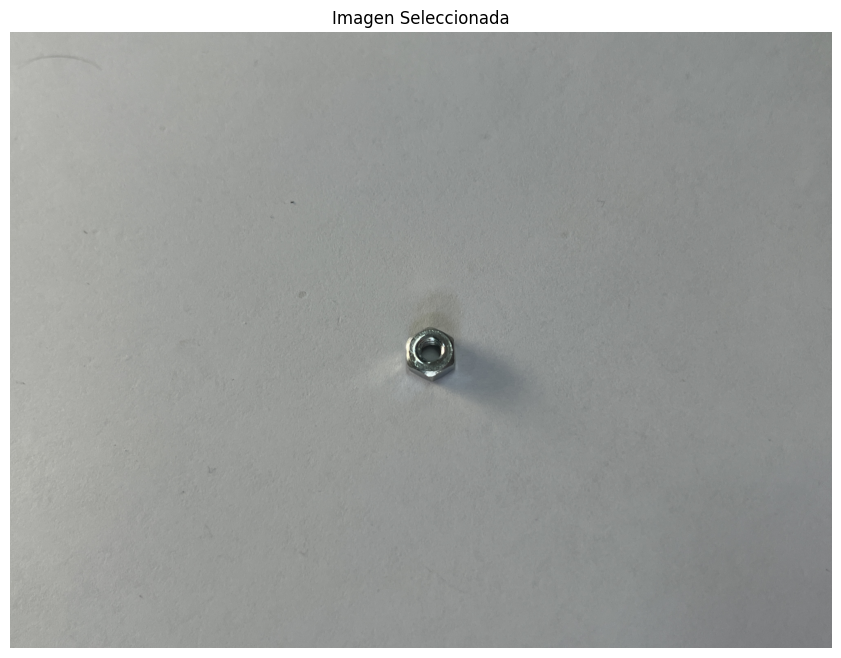

In [6]:
initial_stats, classes = analyze_dataset_structure()

imagen_path, random_image = get_random_image("tuercas")

print(f"Se selecciono la imagen {imagen_path}")
plot_image(random_image, title="Imagen Seleccionada")

## ImagePreprocessor

Se utilizan y observan los outputs de cada una de las transformaciones realizadas durante el preprocesamiento de imagenes

Se selecciono la imagen data/raw/images/all/arandelas/IMG_2795.JPG


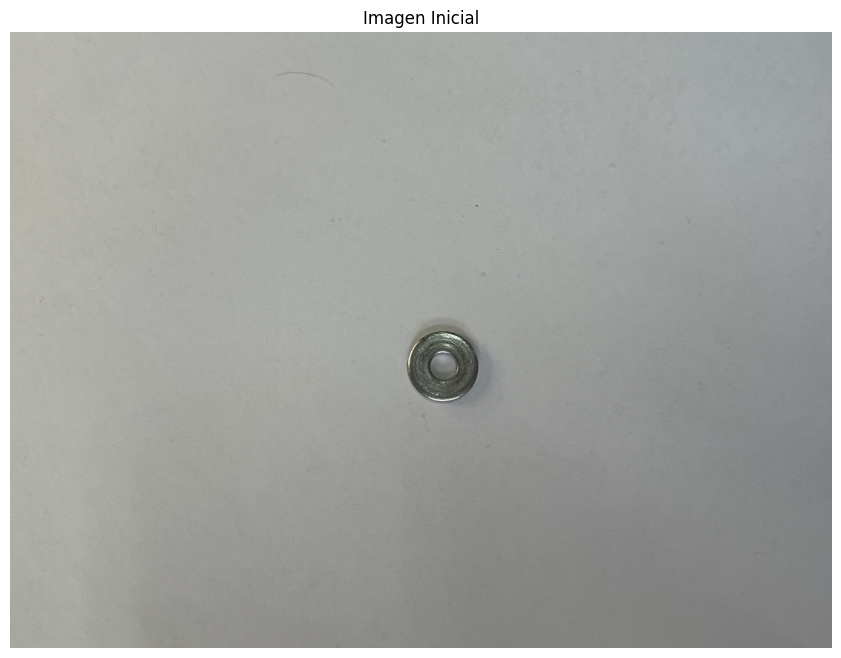

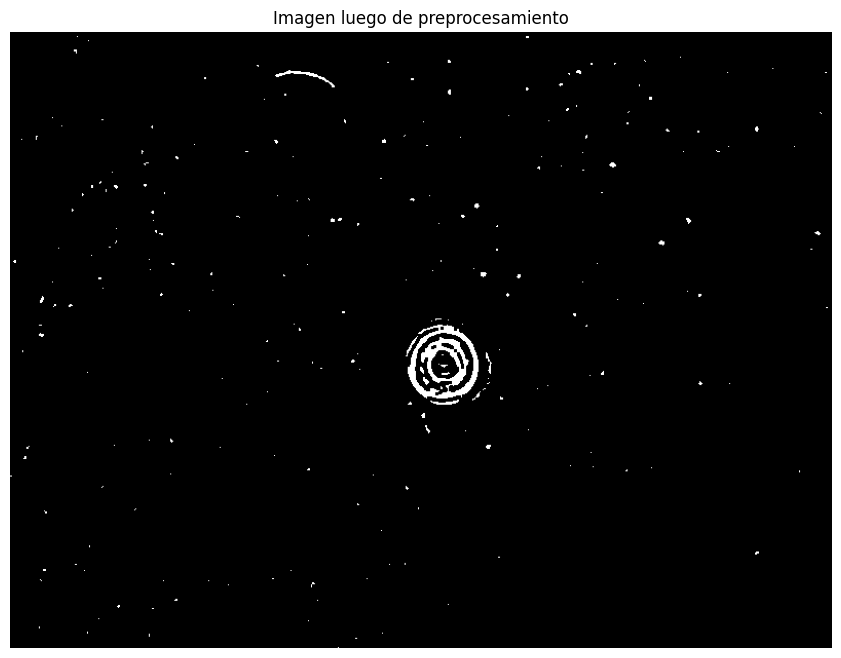

In [15]:
# Agrego Path de ImagePreprocesor

procesador_imagenes = ImagePreprocessor(target_size=(800,600),
                                        blur_kernel_size=(7,7),
                                        binarization_block_size=13,
                                        binarization_C=2,
                                        open_kernel_size=(3,3),
                                        close_kernel_size=(3,3))

#! 1. Eligo una imagen aleatoria
path_image, image = get_random_image("arandelas", seed=61)
print(f"Se selecciono la imagen {path_image}")
plot_image(image, title="Imagen Inicial")

#! Paso a paso de las transformaciones realizadas
#gray_image = procesador_imagenes._convert_to_grayscale(image)
#plot_image(gray_image, title="Imagen en escala de grises")

#standard_size_image = procesador_imagenes._standardize_size(gray_image)
#plot_image(standard_size_image, title="Imagen con tamaño estandarizado")

#blurred_image = procesador_imagenes._apply_gaussian_blur(standard_size_image, kernel_size=(5,5))
#plot_image(blurred_image, title="Imagen luego de suavizado")

#binarize_image = procesador_imagenes._apply_adaptive_binarization(blurred_image)
#plot_image(binarize_image, title="Imagen Binarizada")

#imagen_suavizada = procesador_imagenes._clean_binarization(binarize_image)
#plot_image(imagen_suavizada, title = """Imagen luego de suavizado""")

#! Todo de una
binary_image = procesador_imagenes.process(image)
plot_image(binary_image, title="Imagen luego de preprocesamiento")

## Segmentator

In [8]:
def _quick_visualization(binary_image: np.ndarray, result: Dict):
    """Quick visualization of the segmentation results"""
    # Create visualization image
    vis_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    
    # Draw bounding boxes
    for i, bbox in enumerate(result["bounding_boxes"]):
        x, y, w, h = bbox
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(vis_image, str(i+1), (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Create mask overlay
    mask_overlay = np.zeros_like(vis_image)
    for mask in result["masks"]:
        mask_overlay[mask > 0] = [0, 0, 255]  # Red for masks
    
    # Blend with original
    final_vis = cv2.addWeighted(vis_image, 0.7, mask_overlay, 0.3, 0)
    
    # Add title
    cv2.putText(final_vis, f"Objects: {result['total_objects']}", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Resize if too large
    h, w = final_vis.shape[:2]
    if w > 800:
        final_vis = cv2.resize(final_vis, (800, int(800 * h / w)))
    
    # Display
    cv2.imshow('Segmentation Test Result', final_vis)
    cv2.waitKey(3000)  # Show for 3 seconds
    cv2.destroyAllWindows()

In [18]:
# TEST
from src.agent.Segmentator import Segmentator

# 1. Eligo una imagen aleatoria
#path_image, image = get_random_image("tornillos", seed=31233)
#print(f"Se selecciono la imagen {path_image}")

# 2. Imagen con multiples piezas
#img_path = BASE_PATH / "multi_test" / "WhatsApp Image 2025-10-16 at 12.47.44.JPG"
#image = mpimg.imread(img_path)

#Instanciar segmentador
segmentator = Segmentator(
    min_contour_area=25,
    min_mask_area=150,
    merge_close_boxes=True,
    overlap_threshold=0.3,
    max_distance=5
)

# Realizo segmentacion de la imagen binaria
result = segmentator.process(binary_image)

print(f"================")
# Check data consistency
print("\n🔍 Checking data consistency...")
bbox_count = len(result["bounding_boxes"])
contour_count = len(result["contours"])
mask_count = len(result["masks"])
total_objects = result["total_objects"]
    
print(f"   Bounding boxes: {bbox_count}")
print(f"   Contours: {contour_count}")
print(f"   Masks: {mask_count}")
print(f"   Total objects: {total_objects}")
    
# Check if counts match
if bbox_count == contour_count == mask_count == total_objects:
    print("   ✅ All counts match!")
else:
    print("   ⚠️  Counts don't match - this might indicate a problem")


print("\n🎭 Validating masks...")
for i, mask in enumerate(result["masks"]):
    mask_area = np.sum(mask > 0)
    print(f"   Mask {i+1}: {mask_area} pixels")
        
    # Check if mask is entirely within its bounding box
    if i < len(result["bounding_boxes"]):
        x, y, w, h = result["bounding_boxes"][i]
        mask_roi = mask[y:y+h, x:x+w]
        roi_area = np.sum(mask_roi > 0)
            
        if mask_area == roi_area:
            print(f"      ✅ Mask {i+1} fits perfectly in bounding box")
        else:
            print(f"      ⚠️  Mask {i+1} extends outside bounding box")

_quick_visualization(binary_image, result)

🚀 INICIANDO PROCESO DE SEGMENTACIÓN
   Contornos encontrados: 234
   Contornos validos: 3
   Bounding boxes: 3
   Bounding boxes despues de fusion: 2
   Mascaras extraidas: 2
   x Objeto de area 86 eliminado (filtrado absoluto)
Filtrado preliminar: 1 mascaras eliminadas
   Resultados filtrados:
   * valid_contours: 1
   * bounding_boxes: 1
   * masks: 1

🔍 Checking data consistency...
   Bounding boxes: 1
   Contours: 1
   Masks: 1
   Total objects: 1
   ✅ All counts match!

🎭 Validating masks...
   Mask 1: 1869 pixels
      ✅ Mask 1 fits perfectly in bounding box


## FeatureExtractor

In [10]:
class ContourAnalyzer:
    def __init__(self):
        self.contour_visualizations = {}
    
    def extract_contour_from_mask(self, mask: np.ndarray) -> np.ndarray:
        """
        Extrae el contorno principal de una máscara binaria
        """
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None
        # Tomar el contorno más grande
        main_contour = max(contours, key=cv2.contourArea)
        return main_contour
    
    def visualize_contour_basic(self, mask: np.ndarray, title: str = "Contorno") -> np.ndarray:
        """
        Visualización básica del contorno sobre la máscara
        """
        contour = self.extract_contour_from_mask(mask)
        if contour is None:
            return mask
        
        # Crear imagen de visualización
        vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        
        # Dibujar contorno
        cv2.drawContours(vis, [contour], -1, (0, 255, 0), 2)  # Verde
        
        # Dibujar puntos del contorno
        for point in contour:
            cv2.circle(vis, tuple(point[0]), 2, (0, 0, 255), -1)  # Rojo
        
        return vis
    
    def visualize_contour_analysis(self, mask: np.ndarray, bbox: Tuple) -> Dict:
        """
        Análisis completo del contorno con múltiples visualizaciones
        """
        contour = self.extract_contour_from_mask(mask)
        if contour is None:
            return {}
        
        visualizations = {}
        
        # 1. Contorno básico
        basic_vis = self.visualize_contour_basic(mask, "Contorno Básico")
        visualizations['basic'] = basic_vis
        
        # 2. Contorno con bounding box
        bbox_vis = basic_vis.copy()
        x, y, w, h = bbox
        cv2.rectangle(bbox_vis, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Azul
        visualizations['with_bbox'] = bbox_vis
        
        # 3. Contorno con convex hull
        hull_vis = basic_vis.copy()
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_vis, [hull], -1, (255, 255, 0), 2)  # Cian
        visualizations['with_hull'] = hull_vis
        
        # 4. Contorno con aproximación poligonal
        poly_vis = basic_vis.copy()
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        cv2.drawContours(poly_vis, [approx], -1, (255, 0, 255), 3)  # Magenta
        visualizations['polygonal'] = poly_vis
        
        # 5. Contorno con ejes principales
        axis_vis = basic_vis.copy()
        self._draw_principal_axes(axis_vis, contour)
        visualizations['with_axes'] = axis_vis
        
        return visualizations
    
    def _draw_principal_axes(self, image: np.ndarray, contour: np.ndarray):
        """Dibuja los ejes principales del contorno"""
        # Ajustar una elipse al contorno
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(image, ellipse, (0, 255, 255), 2)  # Amarillo
            
            # Centro de la elipse
            center = (int(ellipse[0][0]), int(ellipse[0][1]))
            cv2.circle(image, center, 5, (0, 255, 255), -1)
    
    def display_contour_analysis(self, mask: np.ndarray, bbox: Tuple, obj_id: int):
        """
        Muestra todas las visualizaciones del análisis de contorno
        """
        print(f"\n🔍 ANÁLISIS DETALLADO DEL CONTORNO - Objeto {obj_id}")
        print("=" * 50)
        
        visualizations = self.visualize_contour_analysis(mask, bbox)
        
        for name, vis in visualizations.items():
            # Redimensionar si es muy grande
            h, w = vis.shape[:2]
            if w > 600:
                scale = 600 / w
                vis = cv2.resize(vis, (600, int(h * scale)))
            
            cv2.imshow(f'Contorno {name} - Obj {obj_id}', vis)
            cv2.waitKey(500)  # Mostrar cada una por 0.5 segundos
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [ ]:
# analizador_contorno = ContourAnalyzer()

# for i, mask in enumerate(result["masks"]):
#     bbox = result["bounding_boxes"][i]
#     analizador_contorno.display_contour_analysis(mask, bbox, i+1)


🔍 ANÁLISIS DETALLADO DEL CONTORNO - Objeto 1


In [32]:
from src.agent.FeatureExtractor import FeatureExtractor

# 1. Imagen aleatoria
path_image, image = get_random_image("clavos")
#print(f"Se selecciono la imagen {path_image}")

# 2. Imagen con multiples piezas
#img_path = BASE_PATH / "multi_test" / "WhatsApp Image 2025-10-16 at 12.47.44.JPG"
#image = mpimg.imread(img_path)

binary_image = procesador_imagenes.process(image)

#Instanciar segmentador
segmentator = Segmentator(
    min_contour_area=25,
    min_mask_area=150,
    merge_close_boxes=True,
    overlap_threshold=0.3,
    max_distance=5
)

# Realizo segmentacion de la imagen binaria
#
result = segmentator.process(binary_image)

# Instanciar FeatureExtractor
extractor = FeatureExtractor()

features = extractor.extract_features(result["bounding_boxes"], result["masks"])

🚀 INICIANDO PROCESO DE SEGMENTACIÓN
   Contornos encontrados: 182
   Contornos validos: 4
   Bounding boxes: 4
   Bounding boxes despues de fusion: 2
   Mascaras extraidas: 2
   x Objeto de area 43 eliminado (filtrado absoluto)
Filtrado preliminar: 1 mascaras eliminadas
   Resultados filtrados:
   * valid_contours: 1
   * bounding_boxes: 1
   * masks: 1
🚀 INICIANDO EXTRACCION DE CARACTERISTICAS
   🔍 Analizando objeto 1...
   ✅ Contorno principal: 1254.0
   ✅ Perímetro contorno: 288.77
   ✅ Área convex hull: 2207.50
   ✅ Perímetro convex hull: 257.02
   ✅ Momentos Hu: [0.9242918935360562, 0.7888436221956779, 0.0553930625101475, 0.03129156365742552, 0.0012933973985832414, 0.02726036103079079, 0.00015601086176523013]
   ✅ Numero de vertices: 6

   ✅ Pieza 1 - Características OPTIMIZADAS:
      🔴 Circularidad:       0.189
      📏 Esbeltez:           0.351
      🏢 Solidez:            0.568
      🔩 Firma hexagonal:    1.000
      ⚖️  Relación cabeza:    0.000
      🧵 Complejidad rosca:  0.61

### Dividir el dataset en Train y Test

In [13]:
import random
import shutil
from pathlib import Path

def split_dataset():
    """
    Divide el dataset 70-30 entre train y test desde el directorio all
    """

    # Crear directorio train y test si no existen
    TRAIN_PATH.mkdir(parents=True, exist_ok=True)
    TEST_PATH.mkdir(parents=True, exist_ok=True)
    
    # Para cada clase en train
    for class_dir in ALL_PATH.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            print(f"Procesando clase: {class_name}")
            
            # Obtener todas las imágenes
            image_files = list(class_dir.glob("*.*"))
            random.shuffle(image_files)
            
            # Calcular splits
            split_index = int(0.7 * len(image_files))
            train_images = image_files[:split_index]
            test_images = image_files[split_index:]
            
            # Crear directorios de clase en test
            train_class_dir = TRAIN_PATH / class_name
            test_class_dir = TEST_PATH / class_name
            train_class_dir.mkdir(exist_ok=True)
            test_class_dir.mkdir(exist_ok=True)
            
            # Copiar imágenes a train
            for image in train_images:
                shutil.copy2(str(image), str(train_class_dir / image.name))

            # Copiar imágenes a test
            for image in test_images:
                shutil.copy2(str(image), str(test_class_dir / image.name))
            
            print(f"  Train: {len(train_images)} imágenes")
            print(f"  Test: {len(test_images)} imágenes")
            print(f"  Total: {len(image_files)} imágenes")

In [14]:
# Solo ejecutar 1 vez
#split_dataset()